In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

2025-09-04 12:47:17.764840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 12:47:17.793930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 12:47:18.453040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv('../data/mucnuoc_gio_preprocess.csv')
df.head(3)

,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [3]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [4]:
# Thiết lập features và target
features = ['q64']
target = 'q64'

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

In [5]:
def create_dataset_and_train_model_fixed(past_window, future_window, scaled_data, features, target, scaler):
    """
    Tạo dataset và train model với window size cụ thể - PHIÊN BẢN SỬA LỖI
    """
    print(f"\n🔄 Training với Past Window: {past_window}, Future Window: {future_window}")

    # Tạo dữ liệu window - FIXED VERSION
    X, y = [], []
    target_idx = features.index(target)

    for i in range(len(scaled_data) - past_window - future_window):
        # Input: past_window timesteps với tất cả features
        X_window = scaled_data[i:i+past_window]

        # Output: future_window timesteps chỉ với target feature
        # THAY ĐỔI QUAN TRỌNG: Không dùng .mean() nữa!
        y_sequence = scaled_data[i+past_window:i+past_window+future_window, target_idx]

        X.append(X_window)
        y.append(y_sequence)

    X = np.array(X, dtype=np.float32)  # Shape: (samples, past_window, n_features)
    y = np.array(y, dtype=np.float32)  # Shape: (samples, future_window)

    print(f"📊 Kích thước dữ liệu: X={X.shape}, y={y.shape}")

    # Chia train/test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Tạo model - CẦN SỬA ARCHITECTURE
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=(past_window, len(features))),
        SimpleRNN(32, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(future_window)  # Output = future_window timesteps
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early Stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    print("🚀 Bắt đầu training...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    # Dự đoán
    y_pred = model.predict(X_test, verbose=0)  # Shape: (test_samples, future_window)

    # Chuyển đổi ngược về đơn vị gốc
    q64_index = features.index('q64')
    q64_min = scaler.data_min_[q64_index]
    q64_max = scaler.data_max_[q64_index]

    y_pred_inv = y_pred * (q64_max - q64_min) + q64_min
    y_test_inv = y_test * (q64_max - q64_min) + q64_min

    # Đánh giá - có thể tính cho từng timestep hoặc overall
    # Cách 1: Overall metrics (flatten all predictions)
    mae_overall = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
    mse_overall = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
    rmse_overall = np.sqrt(mse_overall)
    r2_overall = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

    # Cách 2: Per-timestep metrics
    timestep_metrics = []
    for t in range(future_window):
        mae_t = mean_absolute_error(y_test_inv[:, t], y_pred_inv[:, t])
        r2_t = r2_score(y_test_inv[:, t], y_pred_inv[:, t])
        timestep_metrics.append({'timestep': t+1, 'mae': mae_t, 'r2': r2_t})

    print(f"✅ Overall - MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}, R²: {r2_overall:.4f}")
    print(f"📈 Stopped at epoch: {len(history.history['loss'])}")

    # In metrics cho vài timestep đầu
    print("🔍 Per-timestep performance (first 5):")
    for i in range(min(5, len(timestep_metrics))):
        t_metric = timestep_metrics[i]
        print(f"   Timestep {t_metric['timestep']}: MAE={t_metric['mae']:.4f}, R²={t_metric['r2']:.4f}")

    return {
        'past_window': past_window,
        'future_window': future_window,
        'y_test': y_test_inv,          # Shape: (samples, future_window)
        'y_pred': y_pred_inv,          # Shape: (samples, future_window)
        'mae': mae_overall,
        'mse': mse_overall,
        'rmse': rmse_overall,
        'r2': r2_overall,
        'timestep_metrics': timestep_metrics,
        'history': history,
        'epochs_trained': len(history.history['loss'])
    }


In [6]:
# Định nghĩa các window sizes cần test
window_sizes = [12,24,48]
results = []

print("🎯 Bắt đầu training với các window sizes khác nhau...")
print("=" * 60)

# Chạy training cho từng window size
for window_size in window_sizes:
    past_window = window_size
    future_window = 2

    result = create_dataset_and_train_model_fixed(
        past_window, future_window,
        scaled_df[features].values.astype(np.float32),
        features, target, scaler
    )
    results.append(result)

print("\n" + "=" * 60)
print("🎉 Hoàn thành training tất cả các window sizes!")

# Tạo bảng so sánh kết quả
print("\n📊 BẢNG SO SÁNH KẾT QUẢ:")
print("-" * 80)
print(f"{'Window Size':<12} {'MAE':<8} {'RMSE':<8} {'R²':<8} {'Epochs':<8}")
print("-" * 80)
for result in results:
    print(f"{result['past_window']:<12} {result['mae']:<8.4f} {result['rmse']:<8.4f} {result['r2']:<8.4f} {result['epochs_trained']:<8}")

# Tìm model tốt nhất
best_result = max(results, key=lambda x: x['r2'])
print(f"\n🏆 Model tốt nhất: Window Size = {best_result['past_window']} (R² = {best_result['r2']:.4f})")

🎯 Bắt đầu training với các window sizes khác nhau...

🔄 Training với Past Window: 12, Future Window: 2
📊 Kích thước dữ liệu: X=(47489, 12, 1), y=(47489, 2)


W0000 00:00:1756990050.127769    4396 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1756990050.133192    4396 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1756990050.210918    4396 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0
2025-09-04 12:47:30.324423: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_INVALID_PTX'

2025-09-04 12:47:30.324436: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunc

InternalError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Cast] name: 

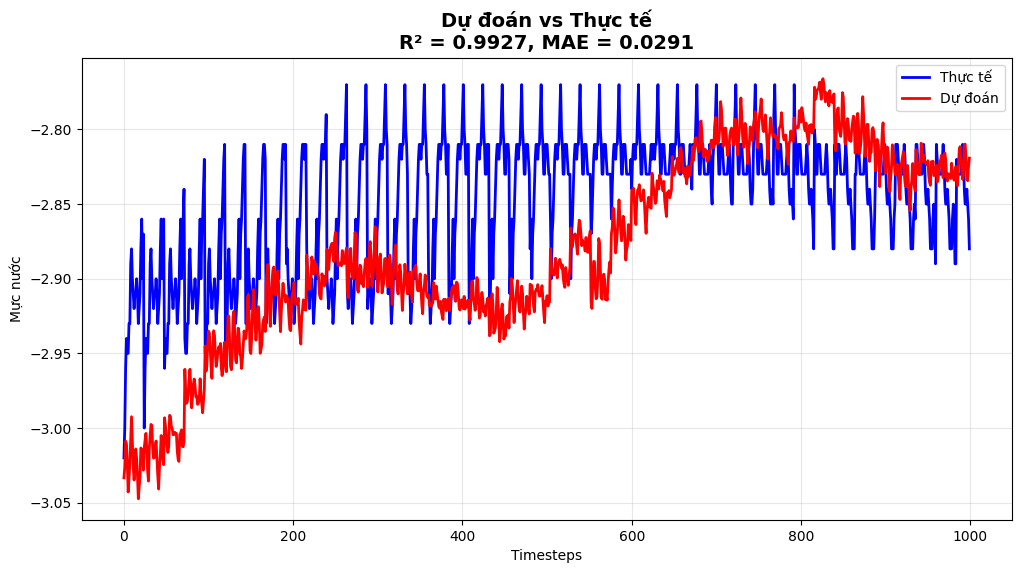

In [ ]:
def plot_single_model(result, sample_size=1000, title="Dự đoán vs Thực tế"):
    """
    Vẽ biểu đồ cho 1 model duy nhất
    """
    plt.figure(figsize=(12, 6))

    # Lấy dữ liệu
    y_test = result['y_test'].flatten()
    y_pred = result['y_pred'].flatten()

    # Chỉ lấy một phần dữ liệu
    if len(y_test) > sample_size:
        y_test = y_test[:sample_size]
        y_pred = y_pred[:sample_size]

    # Vẽ
    x_axis = range(len(y_test))
    plt.plot(x_axis, y_test, label='Thực tế', color='blue', linewidth=2)
    plt.plot(x_axis, y_pred, label='Dự đoán', color='red', linewidth=2)

    plt.title(f'{title}\nR² = {result["r2"]:.4f}, MAE = {result["mae"]:.4f}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Timesteps')
    plt.ylabel('Mực nước')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
plot_single_model(best_result, sample_size=1000, title="Dự đoán vs Thực tế")